In [9]:
import pandas as pd
import re

In [4]:
df = pd.read_csv('cleaned_repos.csv')

In [5]:
df.head()

,language,readme,stemmed,lemmatized,clean
0,JavaScript,"FCC League-For-Good\nThis is a free, open-sour...",fcc leagueforgood thi is a free opensourc web ...,fcc leagueforgood this is a free opensource we...,fcc leagueforgood free opensource web applicat...
1,JavaScript,nba\nNode.js client for nba.com API endpoints\...,nba nodej client for nbacom api endpoint npm i...,nba nodejs client for nbacom api endpoint npm ...,nba nodejs client nbacom api endpoint npm inst...
2,JavaScript,SportsLeague: Laravel 5.4 based system for var...,sportsleagu laravel 54 base system for variou ...,sportsleague laravel 54 based system for vario...,sportsleague laravel 54 based system various s...
3,JavaScript,Team Colors\n\nTeam Colors is a reference of H...,team color team color is a refer of hex rgb cm...,team color team color is a reference of hex rg...,team color team color reference hex rgb cmyk p...
4,JavaScript,vue-sports\n\nA Vue.js project\n\n仿凤凰新闻体育板块+赛事...,vuesport a vuej project vuex vuex build setup ...,vuesports a vuejs project vuex vuex build setu...,vuesports vuejs project vuex vuex build setup ...


In [15]:
words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', str(doc)).split() for doc in df.clean]
df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)
df.to_csv('cleaned_repos.csv', index = False)


In [16]:
df.head()

,language,readme,stemmed,lemmatized,clean,words
0,JavaScript,"FCC League-For-Good\nThis is a free, open-sour...",fcc leagueforgood thi is a free opensourc web ...,fcc leagueforgood this is a free opensource we...,fcc leagueforgood free opensource web applicat...,"[fcc, leagueforgood, free, opensource, web, ap..."
1,JavaScript,nba\nNode.js client for nba.com API endpoints\...,nba nodej client for nbacom api endpoint npm i...,nba nodejs client for nbacom api endpoint npm ...,nba nodejs client nbacom api endpoint npm inst...,"[nba, nodejs, client, nbacom, api, endpoint, n..."
2,JavaScript,SportsLeague: Laravel 5.4 based system for var...,sportsleagu laravel 54 base system for variou ...,sportsleague laravel 54 based system for vario...,sportsleague laravel 54 based system various s...,"[sportsleague, laravel, 54, based, system, var..."
3,JavaScript,Team Colors\n\nTeam Colors is a reference of H...,team color team color is a refer of hex rgb cm...,team color team color is a reference of hex rg...,team color team color reference hex rgb cmyk p...,"[team, color, team, color, reference, hex, rgb..."
4,JavaScript,vue-sports\n\nA Vue.js project\n\n仿凤凰新闻体育板块+赛事...,vuesport a vuej project vuex vuex build setup ...,vuesports a vuejs project vuex vuex build setu...,vuesports vuejs project vuex vuex build setup ...,"[vuesports, vuejs, project, vuex, vuex, build,..."


In [17]:
df.language.value_counts()

C++            50
JavaScript     49
Python         40
Java           10
Name: language, dtype: int64

In [31]:
df.language = df.language.str.strip()

In [32]:
df.language

0      JavaScript
1      JavaScript
2      JavaScript
3      JavaScript
4      JavaScript
          ...    
144           C++
145           C++
146           C++
147           C++
148           C++
Name: language, Length: 149, dtype: object

In [79]:
# js_words = (''.join(df[df.language == 'JavaScript'].clean))
# python_words = (''.join(df[df.language == 'Python'].clean))
# java_words = (''.join(df[df.language == 'Java'].clean))
c_words = (' '.join(df[df.language == 'C++'].clean))
# all_words = (''.join(df.clean))

In [80]:
c_words

'ibiosim computeraided design cad tool aimed modeling analysis design genetic circuit ibiosim primarily target model genetic circuit model representing metabolic network cellsignaling pathway biological chemical system also analyzed ibiosim also includes modeling visualization support multicellular spatial model well capable importing exporting model specified using system biology markup language sbml import level version sbml able export level 3 version 1 support core sbml modeling construct except type fast reaction also support hierarchical model composition layout flux balance constraint array package also tested successfully stochastic benchmark suite curated model biomodels database ibiosim also support synthetic biology open language sbol emerging standard information exchange synthetic biology website ibiosim video demo tool workflow contact chris myers cjmyers myerseceutahedu contributor nathan barker pedro fontanarrosa scott glass kevin jones hiroyuki kuwahara curtis madsen n

In [62]:
all_words

0      fcc leagueforgood free opensource web applicat...
1      nba nodejs client nbacom api endpoint npm inst...
2      sportsleague laravel 54 based system various s...
3      team color team color reference hex rgb cmyk p...
4      vuesports vuejs project vuex vuex build setup ...
                             ...                        
144    physiboss multiscale simulation multicellular ...
145    physiboss multiscale simulation multicellular ...
146    core principle core principle objectoriented a...
147    cath tool protein structure comparison tool ss...
148    skewbiology software diy spectrometer sensor p...
Name: clean, Length: 149, dtype: object

In [74]:
js_freq = pd.Series(js_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
java_freq = pd.Series(java_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [75]:
c_freq.head(10)

ibiosim computeraided design cad tool aimed modeling analysis design genetic circuit ibiosim primarily target model genetic circuit model representing metabolic network cellsignaling pathway biological chemical system also analyzed ibiosim also includes modeling visualization support multicellular spatial model well capable importing exporting model specified using system biology markup language sbml import level version sbml able export level 3 version 1 support core sbml modeling construct except type fast reaction also support hierarchical model composition layout flux balance constraint array package also tested successfully stochastic benchmark suite curated model biomodels database ibiosim also support synthetic biology open language sbol emerging standard information exchange synthetic biology website ibiosim video demo tool workflow contact chris myers cjmyers myerseceutahedu contributor nathan barker pedro fontanarrosa scott glass kevin jones hiroyuki kuwahara curtis madsen na

In [88]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']


def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [91]:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import re
import unicodedata

In [92]:
all_words = clean(' '.join(df.readme))


In [93]:
all_words

['fcc',
 'leagueforgood',
 'free',
 'opensource',
 'web',
 'application',
 'designed',
 'help',
 'sport',
 'league',
 'track',
 'player',
 'team',
 'stats',
 'simplify',
 'daytoday',
 'task',
 'involved',
 'team',
 'management',
 'designed',
 'accommodate',
 'many',
 'popular',
 'sport',
 'join',
 'u',
 'slack',
 'join',
 'u',
 'slack',
 'get',
 'invite',
 'getting',
 'started',
 'prerequisite',
 'nodejs',
 'mongodb',
 'order',
 'authorization',
 'component',
 'app',
 'work',
 'need',
 'registered',
 'google',
 'helpful',
 'walkthrough',
 'process',
 'httpsdevelopersgooglecomidentitysigninwebdevconsoleproject',
 'want',
 'register',
 'type',
 'web',
 'application',
 'set',
 'authorized',
 'javascript',
 'origin',
 'httplocalhost4000',
 'youre',
 'running',
 'application',
 'locally',
 'set',
 'authorized',
 'redirect',
 'uri',
 'httplocalhost4000authgooglecallback',
 'set',
 'google',
 'api',
 'console',
 'dashboard',
 'credential',
 'offered',
 'option',
 'setup',
 'also',
 'need',
 '

In [94]:
js_words = clean(''.join(df[df.language == 'JavaScript'].readme))
python_words = clean(''.join(df[df.language == 'Python'].readme))
java_words = clean(''.join(df[df.language == 'Java'].readme))
c_words = clean(' '.join(df[df.language == 'C++'].readme))
all_words = clean(''.join(df.readme))

In [95]:
js_freq = pd.Series(js_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
java_freq = pd.Series(java_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [99]:
word_counts = (pd.concat([all_freq, js_freq, python_freq, java_freq, c_freq ], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'python', 'java', 'c++'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,javascript,python,java,c++
0,60,5,45,0,10
00,137,0,1,0,136
0005,1,0,0,0,1
001,2,0,0,0,2
0010249996604397894,1,0,0,0,1


In [100]:
word_counts.sort_values(by='all', ascending=False).head(10)


,all,javascript,python,java,c++
data,421,76,291,4,50
visited,398,0,0,0,398
install,308,144,79,11,74
run,286,109,87,10,80
file,273,71,124,16,62
r,248,0,247,0,1
use,239,70,82,8,79
using,217,50,97,13,57
project,209,45,94,20,50
python,198,50,136,0,12


In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Proportion of business vs sports vs tech vs entertainment for the 20 most common words')

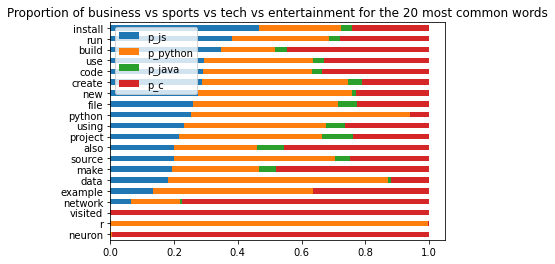

In [109]:

# plt.figure(figsize=(12,12))
(word_counts
 .assign(p_js=word_counts.javascript / word_counts['all'],
         p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.java / word_counts['all'],
         p_c=word_counts['c++'] / word_counts['all'])
 .sort_values(by='all')
 [['p_js', 'p_python', 'p_java', 'p_c']]
 .tail(20)
 .sort_values('p_js')
 .plot.barh(stacked=True))
plt.title('Proportion of business vs sports vs tech vs entertainment for the 20 most common words')